In [ ]:
!Задачи

# Дмитрий Ильин
# Задачи генерации в NLP - Домашнее задание №1

In [ ]:
!pip install datasets transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.6 MB/s eta 0:00:00


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Callable, Iterable
from dataclasses import dataclass, field
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
import gc
import torch
import datasets
from torch.utils.data import Dataset, DataLoader, random_split
from transformers.optimization import get_linear_schedule_with_warmup
from transformers import AutoTokenizer, AutoModel

In [ ]:
from google.colab import files, drive

# Параметры

In [ ]:
@dataclass
class Params:
    root_dir = "/content/drive/My Drive/MIPT/NLPGen/HW1"
    raw_dataset_path = os.path.join(root_dir, "Friends.csv")
    train_dataset_path = os.path.join(root_dir, "train.csv")
    joey_dataset_path = os.path.join(root_dir, "joey.csv")

    model_name = "distilbert-base-uncased"
    MAX_LENGTH = 128

    # Bi-encoder
    seed = 10
    train_ratio = 0.8
    batch_size = 16
    lr = 2e-6
    n_epochs = 10
    sbert_softmax_model_path = os.path.join(root_dir, "sbert_softmax_lr_2e-6")


params = Params()

# 1. Подготовка датасета
За основу взят датасет с Kaggle, содержащий сценарий к сериалу "Друзья".


In [ ]:
drive.mount("/content/drive", force_remount=True)

## 1.1. Загружаем датасет с Kaggle

In [ ]:
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d gopinath15/friends-netflix-script-data

 54% 1.00M/1.87M [00:00<00:00, 1.64MB/s]
100% 1.87M/1.87M [00:00<00:00, 2.70MB/s]


In [ ]:
!unzip friends-netflix-script-data.zip

Archive:  friends-netflix-script-data.zip
  inflating: Friends.csv             


In [ ]:
!cp /content/Friends.csv "/content/drive/My Drive/MIPT/NLPGen/HW1/Friends.csv"

## 1.2. Предобрабтка

In [ ]:
raw_df = pd.read_csv(params.raw_dataset_path)
raw_df

,Text,Speaker,Episode,Season,Show
0,Originally written by Marta Kauffman and David...,NaN,Episode-01-The One Where Monica Gets a New Roo...,Season-01,Friends
1,Transcribed by guineapig.,NaN,Episode-01-The One Where Monica Gets a New Roo...,Season-01,Friends
2,CENTRAL PERK. (ALL PRESENT EXCEPT RACHEL AND ...,SCENE 1,Episode-01-The One Where Monica Gets a New Roo...,Season-01,Friends
3,There's nothing to tell! He's just some guy I...,MONICA,Episode-01-The One Where Monica Gets a New Roo...,Season-01,Friends
4,"C'mon, you're going out with the guy! There's...",JOEY,Episode-01-The One Where Monica Gets a New Roo...,Season-01,Friends
...,...,...,...,...,...
69969,Then I'm happy too. (They're still hugging - ...,Ross,Episode-15-The One Where Estelle Dies,Season-10,Friends
69970,COMMERCIAL BREAK,NaN,Episode-15-The One Where Estelle Dies,Season-10,Friends
69971,Estelle's memorial service. Joey is giving a ...,[Scene,Episode-15-The One Where Estelle Dies,Season-10,Friends
69972,Thank you all for coming. We're here today to...,Joey,Episode-15-The One Where Estelle Dies,Season-10,Friends


Уберем из датасета ненужных спикеров, лишние колонки, а также приведем имена спикеров к единообразному виду.

In [ ]:
filtered_df = raw_df[["Text", "Speaker"]]
filtered_df = filtered_df.dropna(subset=["Speaker"])

excluded_starts_regex = r"(?i)^\[|^\(|^\{|^Written|^Transcribed|^With|^Story|^Teleplay|^Directed"
filtered_df = filtered_df[~filtered_df["Speaker"].str.contains(excluded_starts_regex, na=False)]

filtered_df = filtered_df[~filtered_df["Speaker"].str.match(r"(?i)^SCENE")]

filtered_df["Speaker"] = filtered_df["Speaker"].str.lower().str.capitalize()

In [ ]:
filtered_df

,Text,Speaker
3,There's nothing to tell! He's just some guy I...,Monica
4,"C'mon, you're going out with the guy! There's...",Joey
5,So does he have a hump? A hump and a hairpiece?,Chandler
6,"Wait, does he eat chalk?",Phoebe
8,"Just, 'cause, I don't want her to go through ...",Phoebe
...,...,...
69966,"Yeah! I'm going to Paris. Thank you, Ross!",Rachel
69967,"Yeah, yeah, oh! (They hug)",Ross
69968,"Oh! Oh, I'm so happy.",Rachel
69969,Then I'm happy too. (They're still hugging - ...,Ross


Если спикер говорит несколько фраз подряд, то соединим их в одну фразу.

In [ ]:
filtered_df["new_speaker"] = (filtered_df["Speaker"] != filtered_df["Speaker"].shift(1)).astype(int)
filtered_df["group"] = filtered_df["new_speaker"].cumsum()
aggregated_df = filtered_df.groupby(["group", "Speaker"], as_index=False).agg({"Text": " ".join})
aggregated_df = aggregated_df.drop(columns=["group"])
aggregated_df = aggregated_df[["Speaker", "Text"]]

In [ ]:
aggregated_df

,Speaker,Text
0,Monica,There's nothing to tell! He's just some guy I...
1,Joey,"C'mon, you're going out with the guy! There's..."
2,Chandler,So does he have a hump? A hump and a hairpiece?
3,Phoebe,"Wait, does he eat chalk? Just, 'cause, I don..."
4,Monica,"Okay, everybody relax. This is not even a dat..."
...,...,...
59271,Rachel,"Yeah! I'm going to Paris. Thank you, Ross!"
59272,Ross,"Yeah, yeah, oh! (They hug)"
59273,Rachel,"Oh! Oh, I'm so happy."
59274,Ross,Then I'm happy too. (They're still hugging - ...


In [ ]:
speaker_counts = aggregated_df["Speaker"].value_counts()
top_50_speakers = speaker_counts.head(50)

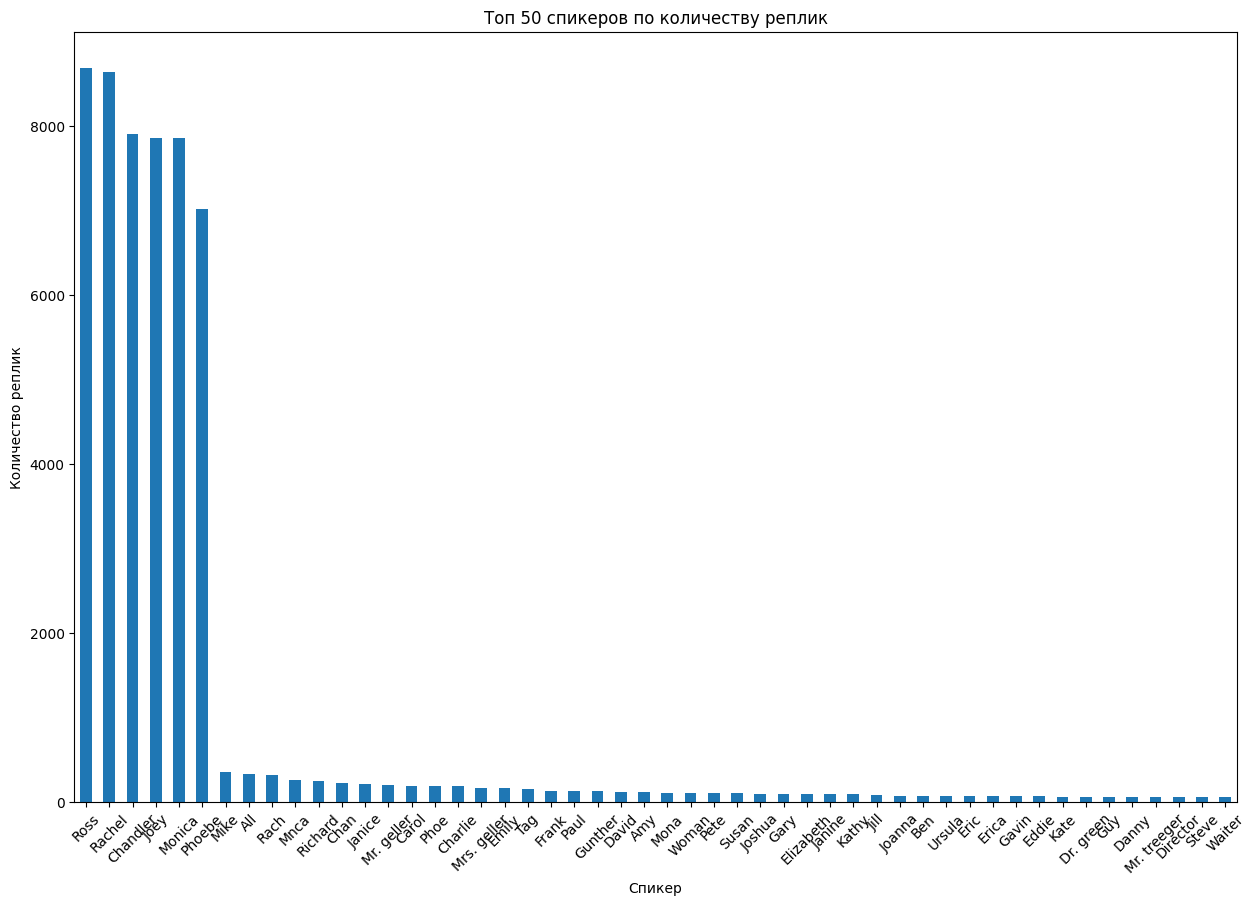

In [ ]:
plt.figure(figsize=(15, 10))
top_50_speakers.plot(kind="bar")
plt.title("Топ 50 спикеров по количеству реплик")
plt.xlabel("Спикер")
plt.ylabel("Количество реплик")
plt.xticks(rotation=45)
plt.show()

## 1.3. Добавление дополнительных колонок с "положительными" и "отрицательными" примерами ответов на реплику

In [ ]:
train_df = aggregated_df[1:-1].copy()

train_df["previous_answer"] = None
train_df["positive_answer"] = None
train_df["negative_answer"] = None
train_df["responder"] = None

# Заполняем данные
n = len(aggregated_df) - 1

for i in range(1, n):
    train_df.at[i, "previous_answer"] = aggregated_df.iloc[i - 1]["Text"]
    train_df.at[i, "responder"] = aggregated_df.iloc[i + 1]["Speaker"]
    train_df.at[i, "positive_answer"] = aggregated_df.iloc[i + 1]["Text"] # Положительный ответ - следующая фраза в диалоге
    random_index = random.choice([x for x in range(1, n) if x != i])
    train_df.at[i, "negative_answer"] = aggregated_df.iloc[random_index]["Text"] # Отрицательный ответ - случайная фраза, не являющаяся следующей за текущей

train_df.reset_index(drop=True, inplace=True)

In [ ]:
train_df

,Speaker,Text,previous_answer,positive_answer,negative_answer,responder
0,Joey,"C'mon, you're going out with the guy! There's...",There's nothing to tell! He's just some guy I...,So does he have a hump? A hump and a hairpiece?,"Yeah, I know, I sleep in the next room.",Chandler
1,Chandler,So does he have a hump? A hump and a hairpiece?,"C'mon, you're going out with the guy! There's...","Wait, does he eat chalk? Just, 'cause, I don...",He’s so cute.,Phoebe
2,Phoebe,"Wait, does he eat chalk? Just, 'cause, I don...",So does he have a hump? A hump and a hairpiece?,"Okay, everybody relax. This is not even a dat...","Except that! (Mr. Zelner enters) Oh, hello, M...",Monica
3,Monica,"Okay, everybody relax. This is not even a dat...","Wait, does he eat chalk? Just, 'cause, I don...","Sounds like a date to me. Alright, so I'm ba...","All right, look you guys... Look, we apprecia...",Chandler
4,Chandler,"Sounds like a date to me. Alright, so I'm ba...","Okay, everybody relax. This is not even a dat...","Oh, yeah. Had that dream.",Oh! Oh! Can I give out the candy? I really wa...,All
...,...,...,...,...,...,...
59269,Ross,Yeah...,All right. ALL RIGHT! I'm gonna do it. I'm go...,"Yeah! I'm going to Paris. Thank you, Ross!","Well, I’ve tried everything. I give up. I gue...",Rachel
59270,Rachel,"Yeah! I'm going to Paris. Thank you, Ross!",Yeah...,"Yeah, yeah, oh! (They hug)","Please, can’t you help me out?",Ross
59271,Ross,"Yeah, yeah, oh! (They hug)","Yeah! I'm going to Paris. Thank you, Ross!","Oh! Oh, I'm so happy.","'Cause uh, this is today's Post (produces one...",Rachel
59272,Rachel,"Oh! Oh, I'm so happy.","Yeah, yeah, oh! (They hug)",Then I'm happy too. (They're still hugging - ...,Also large?,Ross


In [ ]:
train_df.to_csv(params.train_dataset_path, index=False)

# 2. Bi-encoder

## 2.1. Подготовка датасета имени Джо

In [ ]:
train_df = pd.read_csv(params.train_dataset_path)

Отфильтруем датасет, чтобы в нем остались только ответы Джо, так как диалог именно с ним будет имитироваться в чат-боте.

In [ ]:
joey_df = train_df[train_df["responder"] == "Joey"]

In [ ]:
joey_df

,Speaker,Text,previous_answer,positive_answer,negative_answer,responder
6,Chandler,"Then I look down, and I realise there's a pho...","Oh, yeah. Had that dream.",Instead of...?,"There was a pregnancy test in the garbage, an...",Joey
8,Chandler,That's right.,Instead of...?,Never had that dream.,"(interrupting her) Okay, that’s enough honey!",Joey
12,Ross,(MORTIFIED) Hi.,"All of a sudden, the phone starts to ring. An...","This guy says hello, I wanna kill myself.",Well you shouldn’t be. Believe me I wouldn’t ...,Joey
21,Ross,"No I don't, to hell with her, she left me!",No you don't.,And you never knew she was a lesbian...,Mmm. (She pushes him up against the wall and ...,Joey
24,Chandler,Sometimes I wish I was a lesbian... (THE OTHE...,No!! Okay?! Why does everyone keep fixating o...,"Alright Ross, look. You're feeling a lot of p...","That is funny, maybe for my birthday she’ll m...",Joey
...,...,...,...,...,...,...
59216,Phoebe,"Yeah, I wanted to call and tell you that ther...",Estelle?,"(still scared) Ok-ay. I just, I can't believe...",Congratulations!,Joey
59218,Phoebe,"Well, I didn't think I should just drop by...","(still scared) Ok-ay. I just, I can't believe...","No, no, no! (Starts looking around the room, ...","(smiling again) oh, oh, yeah, ok, thanks. I c...",Joey
59220,Phoebe,"Anyway, you did what you had to do. I'm okay.","No, no, no! (Starts looking around the room, ...","Can I ask you something? Uhm, what's it like ...","(To Chandler) Hey man, you feeling any better...",Joey
59222,Phoebe,"(Looks around) It's alright. Look kiddo, I go...","Can I ask you something? Uhm, what's it like ...",Thanks for everything Estelle. Bye. (Hangs up...,"Oh my God, oh my God! Poor Monica!",Joey


In [ ]:
joey_df.to_csv(params.joey_dataset_path, index=False)

In [ ]:
premises = []
hypotheses = []
labels = []

for _, row in joey_df.iterrows():
    premise = f"{row['Text']} [SEP] {row['previous_answer']}" # Добавим в запрос предыдущую реплику для контекста
    positive_hypothesis = row["positive_answer"]
    negative_hypothesis = row["negative_answer"]

    premises.append(premise)
    hypotheses.append(positive_hypothesis)
    labels.append(1)

    premises.append(premise)
    hypotheses.append(negative_hypothesis)
    labels.append(0)

## 2.2. Объявляем и создаем SnliDataset

In [ ]:
class SnliDataset(Dataset):
    def __init__(self, premise_tokens: dict, hypothesis_tokens: dict, labels: Iterable[str]):
        self.premise_tokens = premise_tokens
        self.hypothesis_tokens = hypothesis_tokens
        self.labels = labels
        self._init_data()

    def _init_data(self) -> None:
        self.data = []
        for pt_ids, pt_am, ht_ids, ht_am, label in zip(
            self.premise_tokens["input_ids"], self.premise_tokens["attention_mask"],
            self.hypothesis_tokens["input_ids"], self.hypothesis_tokens["attention_mask"],
            self.labels
        ):
            data = {}
            data["premise_input_ids"] = torch.tensor(pt_ids, dtype=torch.long)
            data["premise_attention_mask"] = torch.tensor(pt_am, dtype=torch.long)
            data["hypothesis_input_ids"] = torch.tensor(ht_ids, dtype=torch.long)
            data["hypothesis_attention_mask"] = torch.tensor(ht_am, dtype=torch.long)
            data["label"] = torch.tensor(label, dtype=torch.long)
            self.data.append(data)

    def __getitem__(self, ix: int) -> dict[str, torch.tensor]:
        return self.data[ix]

    def __len__(self) -> int:
        return len(self.data)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(params.model_name)

In [ ]:
%%time

premise_tokens = tokenizer(premises, max_length=params.MAX_LENGTH, padding="max_length", truncation=True, verbose=True)
hypothesis_tokens = tokenizer(hypotheses, max_length=params.MAX_LENGTH, padding="max_length", truncation=True, verbose=True)
snli_dataset_joey = SnliDataset(premise_tokens, hypothesis_tokens, labels)

CPU times: user 5.47 s, sys: 729 ms, total: 6.2 s
Wall time: 2.63 s


## 2.3. Обучение

In [ ]:
random.seed(params.seed)
np.random.seed(params.seed)

torch.manual_seed(params.seed)
torch.cuda.manual_seed_all(params.seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Подготовка train/test выборки и DataLoader'a

In [ ]:
n_total = len(snli_dataset_joey)
n_train = int(n_total * params.train_ratio)
n_val = n_total - n_train

train_dataset, val_dataset = random_split(snli_dataset_joey, [n_train, n_val])

train_dataloader = DataLoader(train_dataset, batch_size=params.batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=params.batch_size, shuffle=False)

Объявляем модель

In [ ]:
def mean_pool(token_embeds: torch.tensor, attention_mask: torch.tensor) -> torch.tensor:
    in_mask = attention_mask.unsqueeze(-1).expand(token_embeds.size()).float()
    pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(in_mask.sum(1), min=1e-9)
    return pool


def encode(input_texts: list[str], tokenizer: AutoTokenizer, model: AutoModel, device: str = "cpu"
) -> torch.tensor:

    model.eval()
    tokenized_texts = tokenizer(input_texts, max_length=128,
                                padding='max_length', truncation=True, return_tensors="pt")
    token_embeds = model(tokenized_texts["input_ids"].to(device),
                         tokenized_texts["attention_mask"].to(device)).last_hidden_state
    pooled_embeds = mean_pool(token_embeds, tokenized_texts["attention_mask"].to(device))
    return pooled_embeds

In [ ]:
class Sbert(torch.nn.Module):
    def __init__(self, max_length: int = 128):
        super().__init__()
        self.max_length = max_length
        self.bert_model = AutoModel.from_pretrained(params.model_name)
        self.bert_tokenizer = AutoTokenizer.from_pretrained(params.model_name)
        self.linear = torch.nn.Linear(self.bert_model.config.hidden_size * 3, 3)

    def forward(self, data: datasets.arrow_dataset.Dataset) -> torch.tensor:
        premise_input_ids = data["premise_input_ids"].to(device)
        premise_attention_mask = data["premise_attention_mask"].to(device)
        hypothesis_input_ids = data["hypothesis_input_ids"].to(device)
        hypothesis_attention_mask = data["hypothesis_attention_mask"].to(device)

        out_premise = self.bert_model(premise_input_ids, premise_attention_mask)
        out_hypothesis = self.bert_model(hypothesis_input_ids, hypothesis_attention_mask)
        premise_embeds = out_premise.last_hidden_state
        hypothesis_embeds = out_hypothesis.last_hidden_state

        pooled_premise_embeds = mean_pool(premise_embeds, premise_attention_mask)
        pooled_hypotheses_embeds = mean_pool(hypothesis_embeds, hypothesis_attention_mask)

        embeds =  torch.cat([pooled_premise_embeds, pooled_hypotheses_embeds,
                             torch.abs(pooled_premise_embeds - pooled_hypotheses_embeds)],
                            dim=-1)
        return self.linear(embeds)

In [ ]:
sbert_softmax_model = Sbert().to(device)

Optimizer, scheduler и функция потерь

In [ ]:
optimizer = torch.optim.AdamW(sbert_softmax_model.parameters(), lr=params.lr)
total_steps = len(train_dataset) // params.batch_size
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps - warmup_steps)
loss_fn = torch.nn.CrossEntropyLoss()

Функции для обучения

In [ ]:
def get_train_step_fn(
    model: torch.nn.Module, optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler.LambdaLR, loss_fn: torch.nn.CrossEntropyLoss
) -> Callable[[torch.tensor, torch.tensor], float]:

    def train_step_fn(x: torch.tensor, y: torch.tensor) -> float:
        model.train()
        yhat = model(x)
        loss = loss_fn(yhat, y)
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        return loss.item()

    return train_step_fn


def get_val_step_fn(
    model: torch.nn.Module, loss_fn: torch.nn.CrossEntropyLoss
) -> Callable[[torch.tensor, torch.tensor], float]:

    def val_step_fn(x: torch.tensor, y: torch.tensor) -> float:
        model.eval()
        yhat = model(x)
        loss = loss_fn(yhat, y)
        return loss.item()

    return val_step_fn


def mini_batch(
    dataloader: DataLoader,
    step_fn: Callable[[torch.tensor, torch.tensor], float],
    is_training: bool = True
) -> tuple[np.array, list[float]]:

    mini_batch_losses = []

    if is_training:
        print("\nTraining ...")
    else:
        print("\nValidating ...")
    n_steps = len(dataloader)
    for i, data in enumerate(dataloader):
        loss = step_fn(data, data["label"].to(device))
        mini_batch_losses.append(loss)
        if i % (params.batch_size * 100) == 0:
            print(f"step {i:>5}/{n_steps}, loss = {loss: .3f}")

    return np.mean(mini_batch_losses), mini_batch_losses

Обучение

In [ ]:
%%time

train_step_fn = get_train_step_fn(sbert_softmax_model, optimizer, scheduler, loss_fn)
val_step_fn = get_val_step_fn(sbert_softmax_model, loss_fn)

train_losses, train_mini_batch_losses = [], []
val_losses, val_mini_batch_losses = [], []

for epoch in range(1, params.n_epochs + 1):
    train_loss, _train_mini_batch_losses = mini_batch(train_dataloader, train_step_fn)
    train_mini_batch_losses += _train_mini_batch_losses
    train_losses.append(train_loss)

    with torch.no_grad():
        val_loss, _val_mini_batch_losses = mini_batch(val_dataloader, val_step_fn, is_training=False)
        val_mini_batch_losses += _val_mini_batch_losses
        val_losses.append(val_loss)


Training ...
step     0/787, loss =  1.174

Validating ...
step     0/197, loss =  0.698

Training ...
step     0/787, loss =  0.676

Validating ...
step     0/197, loss =  0.698

Training ...
step     0/787, loss =  0.707

Validating ...
step     0/197, loss =  0.698

Training ...
step     0/787, loss =  0.740

Validating ...
step     0/197, loss =  0.698

Training ...
step     0/787, loss =  0.695

Validating ...
step     0/197, loss =  0.698

Training ...
step     0/787, loss =  0.666

Validating ...
step     0/197, loss =  0.698

Training ...
step     0/787, loss =  0.683

Validating ...
step     0/197, loss =  0.698

Training ...
step     0/787, loss =  0.668

Validating ...
step     0/197, loss =  0.698

Training ...
step     0/787, loss =  0.676

Validating ...
step     0/197, loss =  0.698

Training ...
step     0/787, loss =  0.696

Validating ...
step     0/197, loss =  0.698
CPU times: user 40min 38s, sys: 2min 47s, total: 43min 26s
Wall time: 43min 7s


In [ ]:
sbert_softmax_model.bert_model.save_pretrained(params.sbert_softmax_model_path)

In [ ]:
window_size = 32

train_mb_running_loss = []
for i in range(len(train_mini_batch_losses)-window_size):
    train_mb_running_loss.append(np.mean(train_mini_batch_losses[i:i+window_size]))

val_mb_running_loss = []
for i in range(len(val_mini_batch_losses)-window_size):
    val_mb_running_loss.append(np.mean(val_mini_batch_losses[i:i+window_size]))

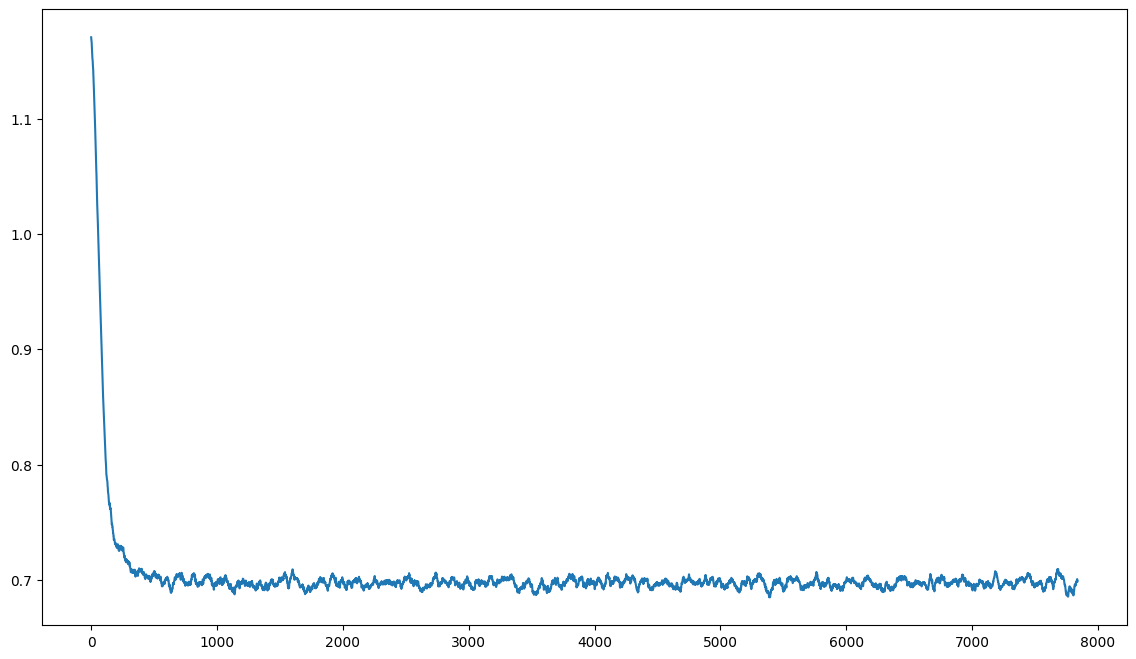

In [ ]:
fix, ax = plt.subplots(figsize=(14, 8))
ax.plot(range(len(train_mb_running_loss)), train_mb_running_loss);

## 2.4. Тест

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
sbert_softmax_model = Sbert().to(device)
sbert_softmax_model.bert_model.from_pretrained(params.sbert_softmax_model_path)

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [ ]:
joey_df = pd.read_csv(params.joey_dataset_path)

In [ ]:
def get_bi_answer(question, context, answers, tokenizer, model, device="cuda"):
    # Объединяем вопрос и контекст
    combined_text = question + " [SEP] " + context

    # Создаем массив с комбинированным текстом вопроса и контекста в качестве первого элемента, а затем добавляем все ответы
    texts_to_encode = [combined_text] + answers

    # Кодируем весь массив текстов за один вызов функции encode
    embeddings = encode(texts_to_encode, tokenizer, model, device).cpu().detach().numpy()

    # Вычисляем косинусную близость между эмбеддингом вопроса-контекста (первым элементом массива эмбеддингов)
    # и эмбеддингами каждого из ответов (остальные элементы массива)
    question_context_embedding = embeddings[0].reshape(1, -1)
    answers_embeddings = embeddings[1:]
    similarities = cosine_similarity(question_context_embedding, answers_embeddings).flatten()

    # Находим индекс ответа с наибольшей косинусной близостью
    best_answer_index = similarities.argmax()

    # Возвращаем наиболее подходящий ответ, его косинусную близость и аккумулированный контекст
    best_answer = answers[best_answer_index]
    updated_context = best_answer + " [SEP] " + combined_text  # Аккумулируем вопрос и контекст с лучшим ответом
    return best_answer, similarities[best_answer_index], updated_context

In [ ]:
sample_answers = joey_df["positive_answer"].sample(n=100, replace=False).tolist() # Возьмем для теста выборку из 100 ответов

In [ ]:
best_answer, similarity_score, updated_context = get_bi_answer(
    "I want pizza", # Вопрос
    "I want to order a delivery", # Контекст
    sample_answers,
    sbert_softmax_model.bert_tokenizer,
    sbert_softmax_model.bert_model,
    device
)

In [ ]:
best_answer

' Why not?! (to Chandler) I’m hungry.'

In [ ]:
similarity_score

0.8180201

In [ ]:
updated_context

' Why not?! (to Chandler) I’m hungry. [SEP] I want pizza [SEP] I want to order a delivery'

## 2.5. Итеративные ответы на вопросы

In [ ]:
def iterative_question_answering(joey_df, tokenizer, model, device="cuda", num_iterations=3):
    updated_context = ""
    for i in range(num_iterations):
        # Случайная выборка 100 ответов
        sample_df = joey_df.sample(n=min(100, len(joey_df)), replace=False)

        # Выбор случайного вопроса из выборки
        random_row = sample_df.sample(n=1)
        question = random_row["Text"].values[0]
        context = random_row["previous_answer"].values[0] if i == 0 else updated_context
        sample_answers = sample_df["positive_answer"].tolist()
        best_answer, similarity_score, updated_context = get_bi_answer(question, context, sample_answers, tokenizer, model, device)

        print(f"Итерация {i+1}:")
        print(f"Вопрос: {question}")
        print(f"Ответ: {best_answer}")
        print(f"Score: {similarity_score}\n")

In [ ]:
iterative_question_answering(joey_df, sbert_softmax_model.bert_tokenizer, sbert_softmax_model.bert_model, device)

Итерация 1:
Вопрос:  Hey.
Ответ:  Hey.
Score: 0.9651762247085571

Итерация 2:
Вопрос:  Ok, um so, I still have to invite Dillon and Emma and Shannon Cooper.
Ответ:  Yeah, definitely, definitely. Ok, what do you wanna see first?
Score: 0.8719785809516907

Итерация 3:
Вопрос:  Hey there you go! (Smiles because Joey used it correctly)
Ответ:  Well I uh, got what I came for. [puts on moose hat] I'll uh, I'll see you guys.
Score: 0.8790067434310913



# 3. Выводы

Несмотря на свои ограничения, модель bi-encoder местами хорошо справляется с задачей поиска ответа на вопросы. Это конечно даже близко не подбирается к возможностям LLM, однако даже в условиях ограниченной выборки ответов модель иногда умудряется удивить и выдать что-то близкое.
Интересно будет попробовать такую модель, например, в задаче поиска ответов в Q&A базе.